In [611]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [612]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [613]:
all_data = pd.concat((train.loc[:,:'SaleCondition'],test.loc[:,:'SaleCondition']))

# Data preprocessing

In [614]:
#Seperating the numerical and categorical feature
numerical_features = []
categorical_features = []
categorical_features  = all_data.select_dtypes(include = 'object').columns
numerical_features = all_data.select_dtypes(exclude = 'object').columns

In [615]:
# checking there are any duplicate records or not
len(all_data['Id']) == len(set(all_data['Id']))

True

In [616]:
all_data.shape

(2919, 80)

# Underastanding the target variable

#Handling the missing data 

In [617]:
from scipy.stats import norm,skew

In [618]:
(mu,sigma) = norm.fit(train['SalePrice'])

mean: 180921.20, standarddeviation : 79415.29


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sales price distribution')

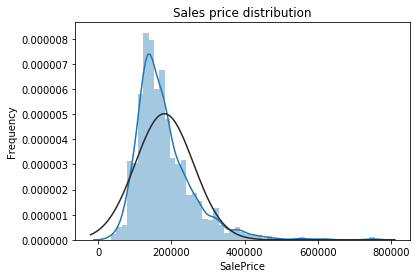

In [619]:
print("mean: {:.2f}, standarddeviation : {:.2f}".format(mu,sigma))
sns.distplot(train['SalePrice'], fit = norm)
plt.ylabel('Frequency')
plt.title('Sales price distribution')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


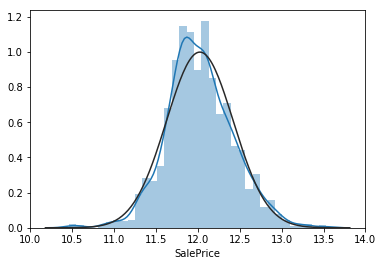

In [620]:
sns.distplot(np.log1p(train['SalePrice']), fit = norm)

In [621]:
train['SalePrice'] = np.log1p(train['SalePrice'])

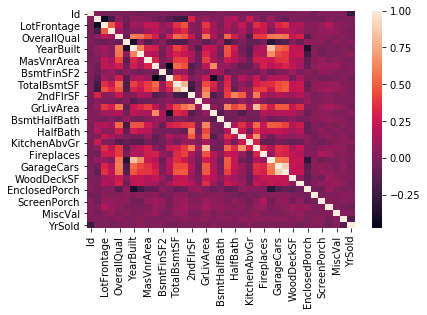

In [622]:
# Finding the correlation among the features
corr = all_data.corr()
sns.heatmap(corr)

In [623]:
na_features = []
for clm in all_data.columns:
    na_count = sum(all_data[clm].isna())
    if na_count > 0.8*(all_data.shape[0]):
        na_features.append(clm)
na_features

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [624]:
# dropping the feature which have hihger nas
#all_data.drop(na_features, axis = 'columns',inplace = True)        
all_data.drop('Id', axis = 'columns',inplace = True) 

In [625]:
# for categorical variable doing one hot encoding
all_data = pd.get_dummies(all_data)

In [626]:
all_data = all_data.fillna(all_data.mean())

In [627]:
all_data.shape

(2919, 288)

# Model building

In [628]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
Y_train = train['SalePrice']

In [629]:
X_train_r,X_test_r,Y_train_r,Y_test_r = train_test_split(X_train,Y_train,test_size = 0.3, random_state = 42)

In [630]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [631]:
def build_model(model,X_train,X_test,Y_train,Y_test):
    model = model.fit(X_train,Y_train)
    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(np.expm1(Y_test),np.expm1(y_predict_test)))
    rmse_train = np.sqrt(mean_squared_error(np.expm1(Y_train),np.expm1(y_predict_train)))
    print("Model accuracy on training set : {} \nModel accuracy on test set : {}".format(rmse_train,rmse_test))

LinearRegression


In [632]:
lr = LinearRegression()

In [633]:
build_model(lr,X_train_r,X_test_r,Y_train_r,Y_test_r )

Model accuracy on training set : 17342.3552197742 
Model accuracy on test set : 60446.62508648924


In [634]:
# ridge regression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
lridge = RidgeCV(alphas = [0.01, 0.03, 0.08, 0.1, 0.3, 0.6,1,3,5,10])
lridge.fit(X_train_r,Y_train_r)
best_alpha = lridge.alpha_

In [635]:
best_alpha

10.0

In [636]:
lridge = Ridge(alpha = 10)

In [637]:
build_model(lridge,X_train_r,X_test_r,Y_train_r,Y_test_r )

Model accuracy on training set : 23636.592832518698 
Model accuracy on test set : 24936.367911126505


Tree implementation

from sklearn.tree import DecisionTreeRegressor

In [638]:
Dt = DecisionTreeRegressor(random_state = 45)

In [639]:
build_model(Dt,X_train_r,X_test_r,Y_train_r,Y_test_r )

Model accuracy on training set : 5.433371595415104 
Model accuracy on test set : 38114.33056690058


Model is highly biased ,overfitting seen here.

#Random forest 

In [640]:
from sklearn.ensemble import RandomForestRegressor

In [641]:
rf = RandomForestRegressor(n_estimators = 300, n_jobs = -1,
                           bootstrap = True, random_state = 40,max_depth = 50)

In [642]:
build_model(rf,X_train_r,X_test_r,Y_train_r,Y_test_r )

Model accuracy on training set : 12638.071581786462 
Model accuracy on test set : 27463.952169244712


#Gradient Boosting 

In [643]:
from sklearn.ensemble import GradientBoostingRegressor

In [644]:
gb = GradientBoostingRegressor(loss = 'ls',learning_rate = 1, n_estimators = 100
                               , random_state = 45)

In [645]:
build_model(gb,X_train_r,X_test_r,Y_train_r,Y_test_r )

Model accuracy on training set : 4033.4598129971123 
Model accuracy on test set : 36927.05761275142


let's use Gridsearch with cross validation on ensemble methods

In [587]:
# Random forest optimisation

In [576]:
from sklearn.model_selection import GridSearchCV

In [582]:
rf = RandomForestRegressor()
params = {
    'n_estimators' : [50,100,200,300,500],
    'max_depth'    : [10,20,50,100]
}

gs = GridSearchCV(estimator=rf,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1)

In [583]:
gs.fit(X_train_r,Y_train_r)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 300, 500], 'max_depth': [10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [584]:
gs.best_params_

{'max_depth': 50, 'n_estimators': 300}

In [649]:
preds = np.expm1(lridge.predict(X_test))

In [650]:
#Prdeiction
sln = pd.DataFrame({'Id':test.Id,'SalePrice':preds})

In [652]:
sln.to_csv("housing_price_pred_Jaikiran.csv", index = False)